# Function Testing Notebook (Windows) - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import mne
import matplotlib.colors as colors


In [2]:
packageroot = Path('../../').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

C:\Users\User\source-code\PyEEG


c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.utils.set_temp_directory(str(packageroot / 'tmp'))

In [4]:
tmpmet = core.DDFBinaryMetadata(packageroot / Path(r'notebooks\tests\test-data\A10 KO 12_13_2023\Cage 2 A10-0_Meta.csv'))
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Wed Dec 13 11:17:32 2023


['Intan Input (1)/PortC C-009',
 'Intan Input (1)/PortC C-010',
 'Intan Input (1)/PortC C-012',
 'Intan Input (1)/PortC C-014',
 'Intan Input (1)/PortC C-015',
 'Intan Input (1)/PortC C-016',
 'Intan Input (1)/PortC C-017',
 'Intan Input (1)/PortC C-019',
 'Intan Input (1)/PortC C-021',
 'Intan Input (1)/PortC C-022']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

WindowsPath('C:/Users/User/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
from dask.distributed import LocalCluster, Client

# Start a local cluster with 3 worker nodes
cluster = LocalCluster(n_workers=3, 
                       processes=True, 
                       threads_per_worker=1, 
                    #    memory_limit='1G',
                       )
# cluster = LocalCluster(n_workers=3, threads_per_worker=2, memory_limit='1G')
# cluster = LocalCluster(n_workers=3, threads_per_worker=3, memory_limit='1G')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 31.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56670,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 31.70 GiB
Comm: tcp://127.0.0.1:56688,Total threads: 1
Dashboard: http://127.0.0.1:56690/status,Memory: 10.57 GiB
Nanny: tcp://127.0.0.1:56673,


In [8]:
# animal_ids = ['A5', 'A10', 'F22', 'G25']
animal_ids = ['A5']
# animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=1)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec(multiprocess_mode='serial')

    war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
        # war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    sar = ao.compute_spike_analysis(multiprocess_mode='dask')
    

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:153: UserWarning: truncate = True. Only the first 1 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [9]:
war.get_result(['all'], allow_missing=True)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr
0,0,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:13.680,True,"[340.2445, 323.54434, 392.14343, 287.55704, 34...","[108016.54, 101200.21, 152518.36, 81025.01, 11...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[5597.8659128090785, 5873.390229194629, 23754....","{'delta': [4002.5935854649256, 4266.2765370048...","[[-2.2393311461395293, 4.016004230917379], [-2...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:17.680,True,"[355.00095, 355.70462, 937.7705, 527.04816, 49...","[125480.39, 126022.64, 879195.4, 277070.97, 24...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[59951.10843858841, 60773.262363882495, 616190...","{'delta': [20599.01035910109, 21049.6836566085...","[[-2.208425704608227, 5.1220083926827265], [-2...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:21.680,True,"[1552.6139, 1577.951, 2028.9061, 1685.8368, 16...","[2408394.8, 2485401.2, 4100196.5, 2829144.0, 2...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2196682.3633737187, 2250912.847727122, 388811...","{'delta': [1736624.1028672764, 1758094.3421242...","[[-2.6307401092387424, 6.823947353355649], [-2...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:25.680,True,"[1229.3511, 1262.778, 1855.7942, 1281.3319, 13...","[1487385.4, 1563496.2, 3426400.8, 1611840.4, 1...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[1338864.3280396787, 1464172.4985059833, 34030...","{'delta': [1040477.6576161707, 1139595.6334356...","[[-2.721078901362543, 6.667150638359723], [-2....","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:29.680,True,"[2346.3865, 2393.4958, 2475.471, 2327.7273, 23...","[5505482.5, 5728515.0, 6120305.0, 5418287.0, 5...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[4479693.363862139, 4523238.683933788, 4862479...","{'delta': [2175279.5945823155, 2165856.5170375...","[[-1.411457114371727, 6.2166052588453615], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:56:37.680,True,"[84.63222, 76.44237, 105.94967, 93.13632, 105....","[7149.9727, 5834.4146, 11199.809, 8663.658, 11...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[6700.10764467349, 5213.395688839463, 10691.46...","{'delta': [1528.2154135681358, 1557.8817414116...","[[-1.5239401160322885, 3.435613517255628], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
112,112,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:56:41.680,True,"[92.89823, 101.97107, 133.0189, 108.83422, 119...","[8629.584, 10393.578, 17687.531, 11841.521, 14...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[4602.846519543421, 5647.13420487474, 11053.14...","{'delta': [1245.31014318922, 2757.706884921751...","[[-1.0817502790634743, 3.0287552295918725], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
113,113,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:56:45.680,True,"[85.03362, 79.29698, 111.22356, 86.194336, 91....","[7230.4717, 6287.0024, 12369.497, 7429.3413, 8...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[5311.107163513523, 3780.33133802495, 10284.00...","{'delta': [734.8017421075681, 769.872483474478...","[[-

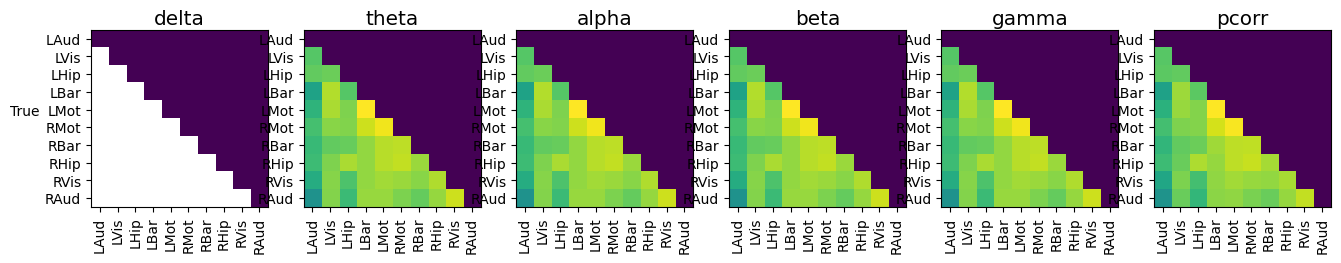

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\animal.py:223: RuntimeWarning: Mean of empty slice
  data_Z = X - np.nanmean(X, axis=axis, keepdims=True)


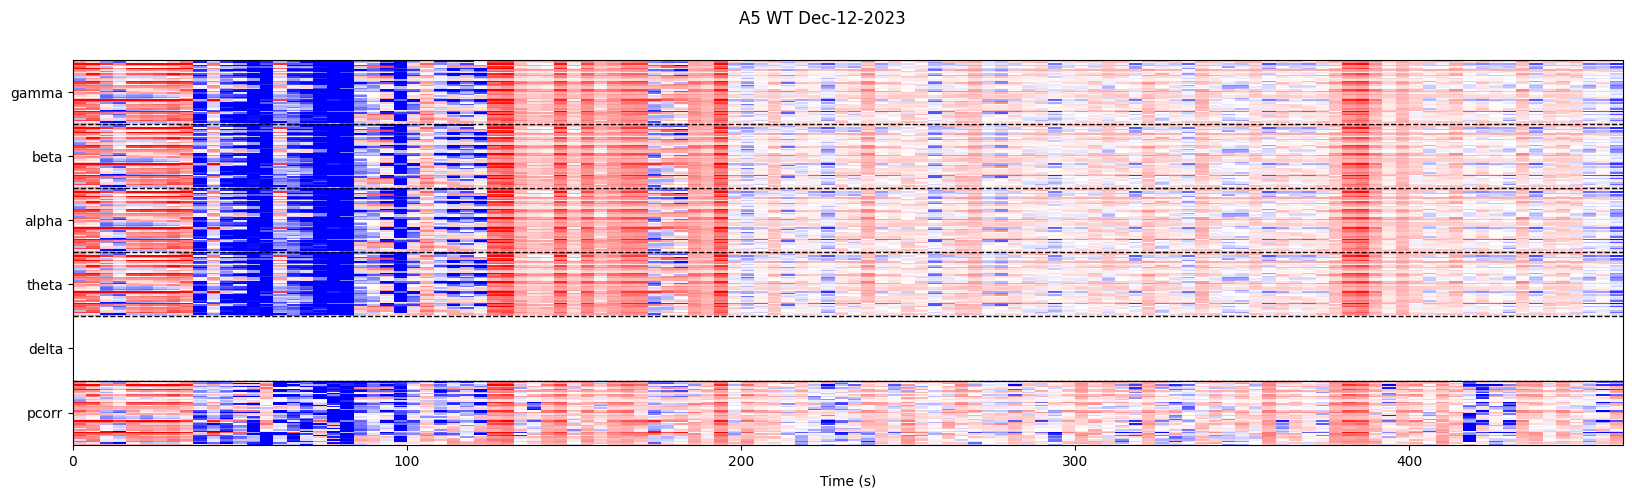

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\animal.py:325: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


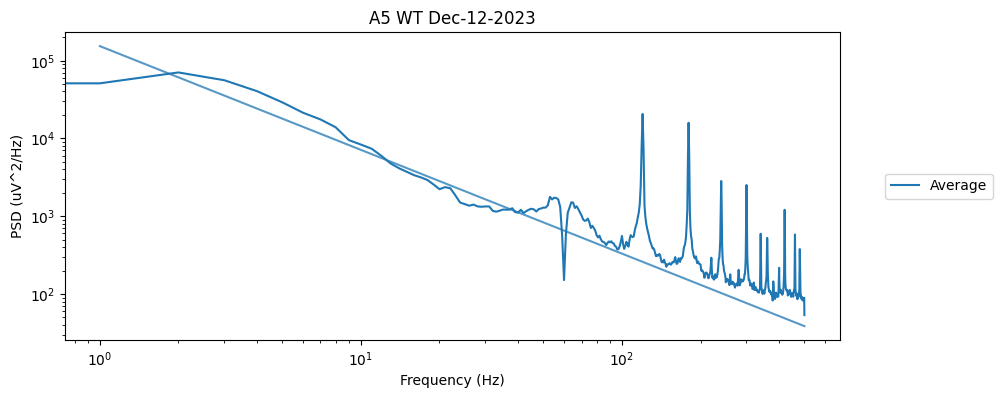

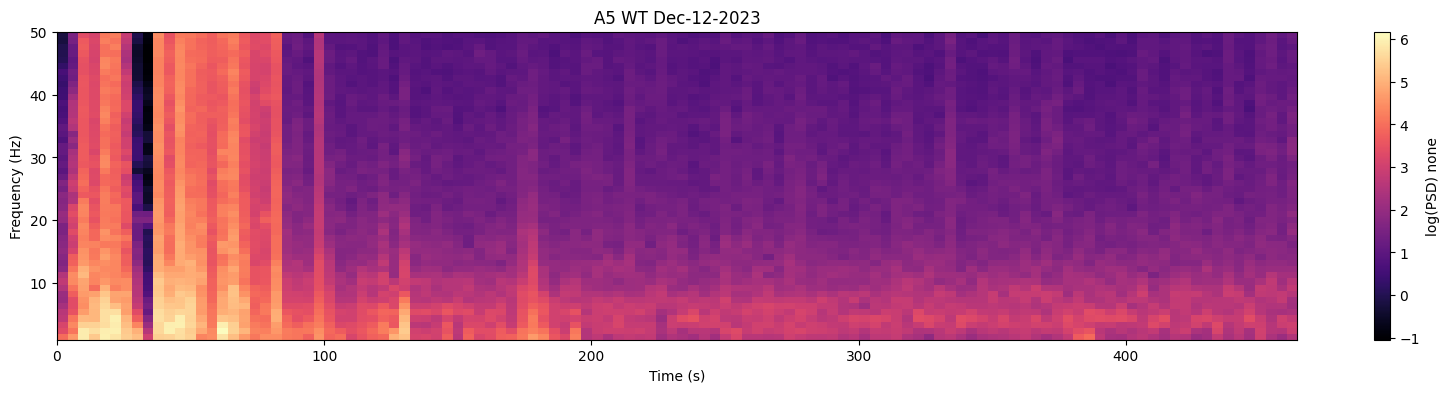

In [10]:
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-0

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\experiment.py:141: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, :, tril_indices[0], tril_indices[1]], axis=-1)


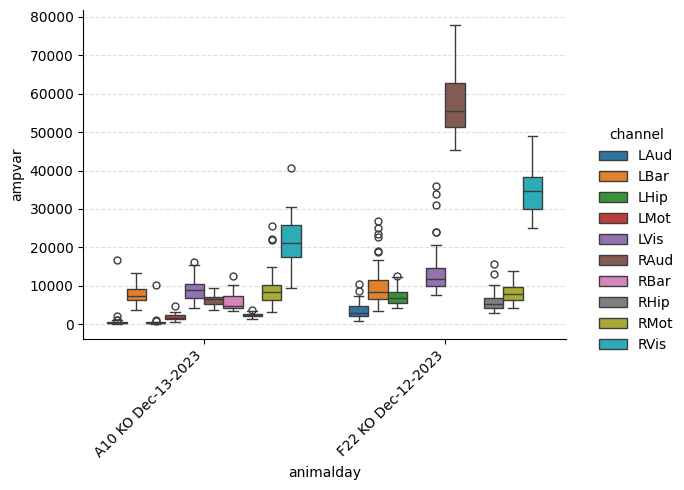

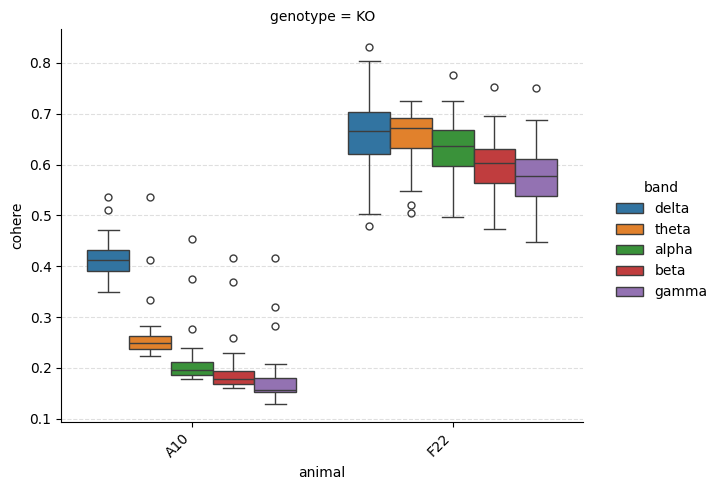

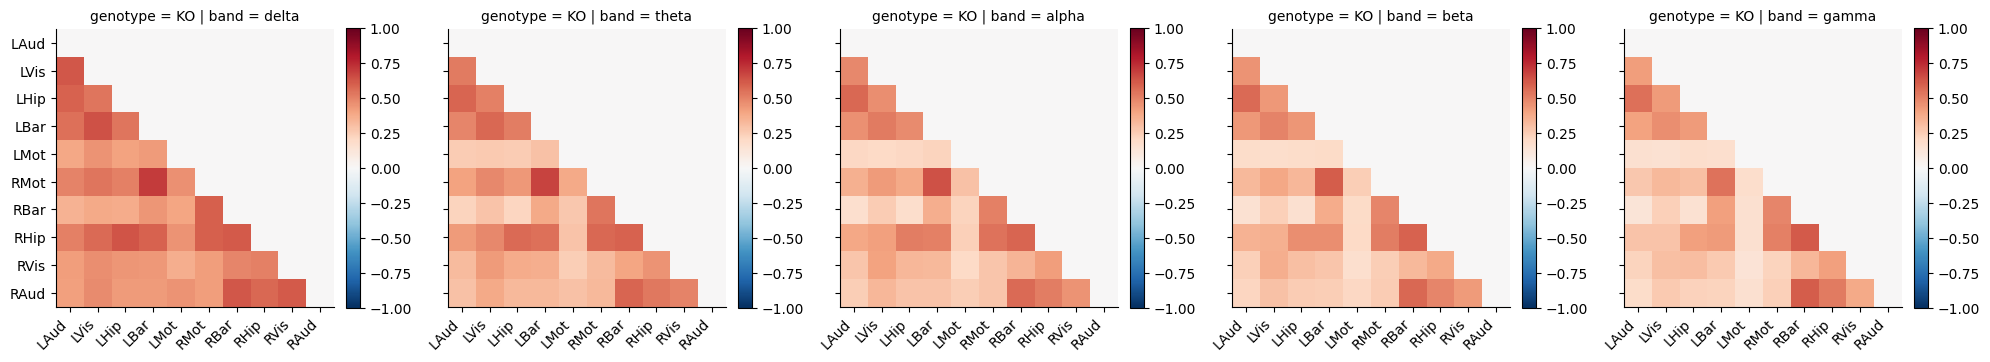

In [11]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    if animal_id == 'F22':
        war.filter_all(reject_channels=['LMot', 'RBar'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


# display(ep._pull_timeseries_dataframe('pcorr', ['isday', 'animal'], collapse_channels=True))

ep.plot_catplot('ampvar', ['animalday'])
ep.plot_catplot('cohere', ['animal', 'genotype'], collapse_channels=True, hue='band')
ep.plot_matrixplot('cohere', ['animal', 'genotype'], col='band')

In [12]:
# sar[0].result
# visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)

In [13]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logger = logging.getLogger()

In [14]:
def analyze_peri_spike_tfr(mne_obj, tmin=-10, tmax=10, l_freq=0.1, h_freq=100):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    events, event_dict = mne.events_from_annotations(raw=raw)
    
    # Common parameters for epoch creation
    epoch_params = {
        'raw': raw,
        'preload': True,
        'baseline': None,
        'event_repeated': 'drop'
    }
    
    # Process each spike type separately
    for unit_id in event_dict.keys():
        print(f"Processing unit: {unit_id}")
        
        # Create spike-centered epochs
        epochs_spike = mne.Epochs(
            **epoch_params,
            event_id={unit_id: event_dict[unit_id]},
            tmin=tmin,
            tmax=tmax
        )
        epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
        fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
        plt.show()
        
        # Create baseline epochs from whole recording
        epochs_baseline = mne.make_fixed_length_epochs(
            raw, 
            duration=tmax-tmin,
            preload=True
        )
        epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Ensure we have comparable numbers of epochs
        n_epochs = min(len(epochs_spike), len(epochs_baseline))
        if n_epochs < 1:
            print(f"No valid epochs for unit {unit_id}")
            continue
            
        epochs_spike = epochs_spike[:n_epochs]
        epochs_baseline = epochs_baseline[:n_epochs]
        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        print("Computing TFR...")
        tfr_spike = epochs_spike.compute_tfr(**tfr_params)
        tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        plot_tfr_ratio(tfr_spike, tfr_baseline)
        
        return tfr_spike, tfr_baseline

def plot_tfr_ratio(tfr_spike, tfr_baseline):
    """Plot the ratio between spike and baseline TFR."""
    pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
    pow_baseline = pow_baseline[:, np.newaxis]
    pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
    pow_spike = np.mean(pow_spike, axis=0)
    pow_ratio = pow_spike / pow_baseline
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    im = ax.imshow(pow_ratio, aspect='auto',
                   extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
                   origin='lower',
                   cmap=plt.cm.RdBu_r,
                   norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--')
    plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
    plt.show()


In [15]:
# Example usage:
mne_obj: mne.io.RawArray = visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result_sas)

Creating RawArray with float64 data, n_channels=10, n_times=466320
    Range : 0 ... 466319 =      0.000 ...   466.319 secs
Ready.


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


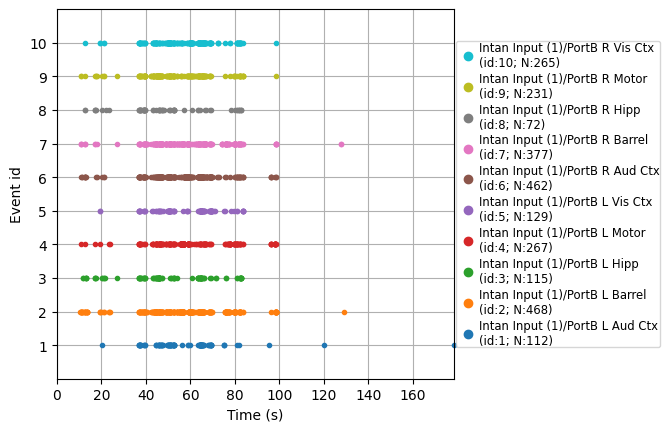

In [16]:
events = mne.events_from_annotations(raw=mne_obj)

fig = mne.viz.plot_events(events[0], sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=events[1])


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]
Processing unit: Intan Input (1)/PortB L Aud Ctx
Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]
Not setting metadata
112 matchi

C:\Users\User\AppData\Local\Temp\ipykernel_17240\2488369046.py:40: RuntimeWarning: filter_length (33001) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.8s


Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
112 matching eve

C:\Users\User\AppData\Local\Temp\ipykernel_17240\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\AppData\Local\Temp\ipykernel_17240\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\AppData\Local\Temp\ipykernel_17240\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
C:\Users\User\AppData\Local\Temp\ipykernel_17240\2488369046.py:41: RuntimeWarning: Cannot find channel coordinates 

KeyboardInterrupt: 

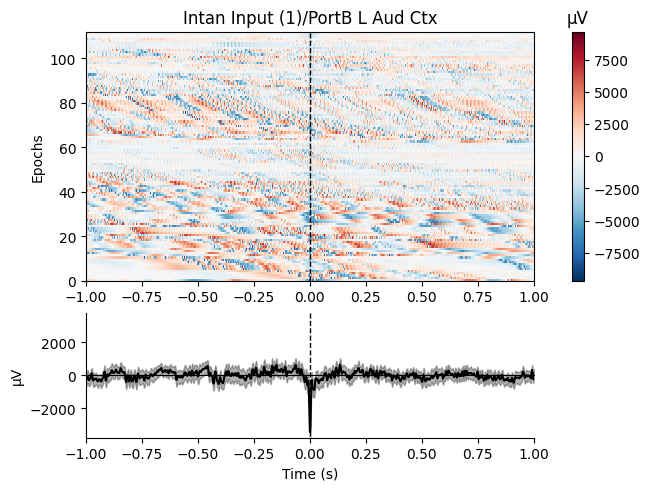

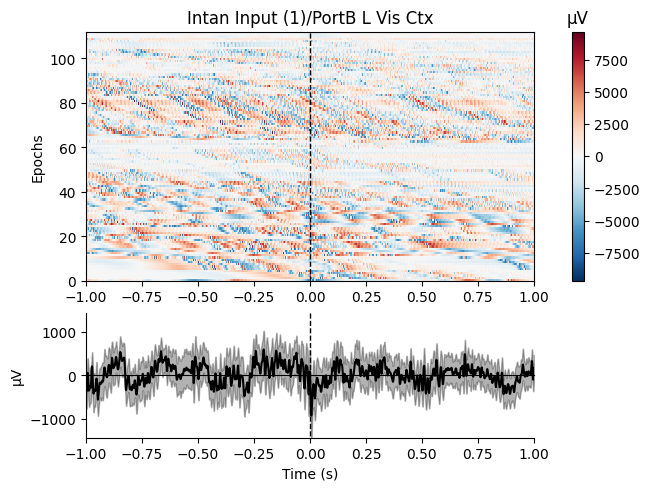

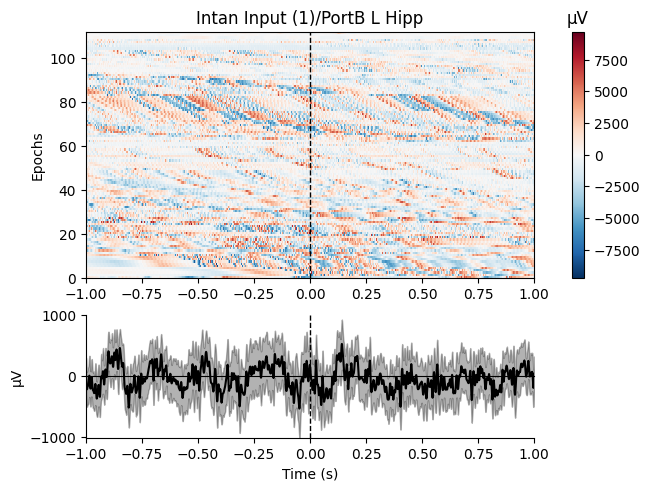

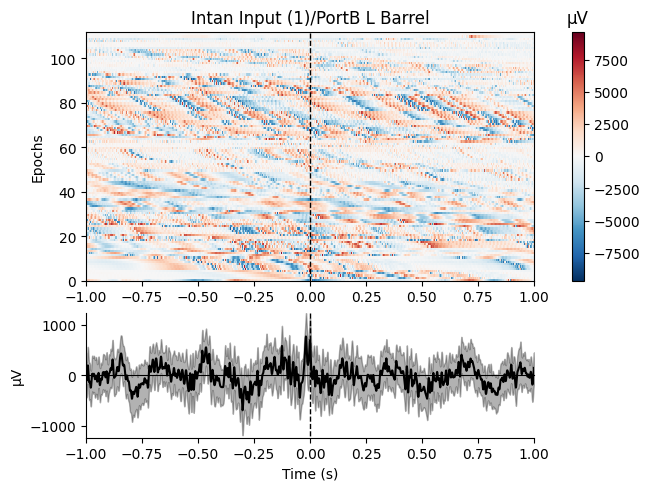

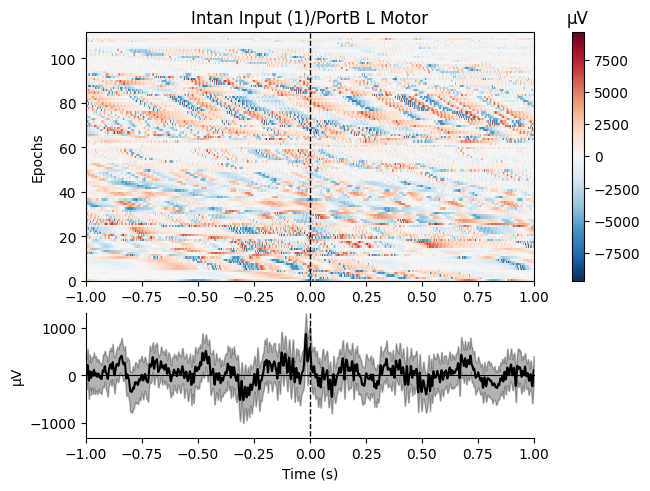

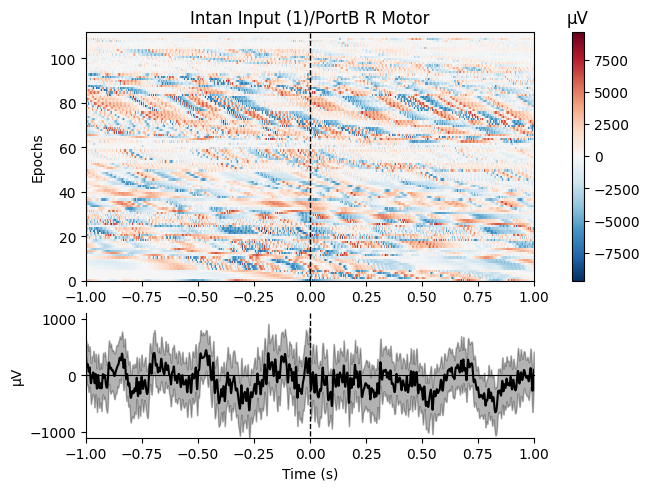

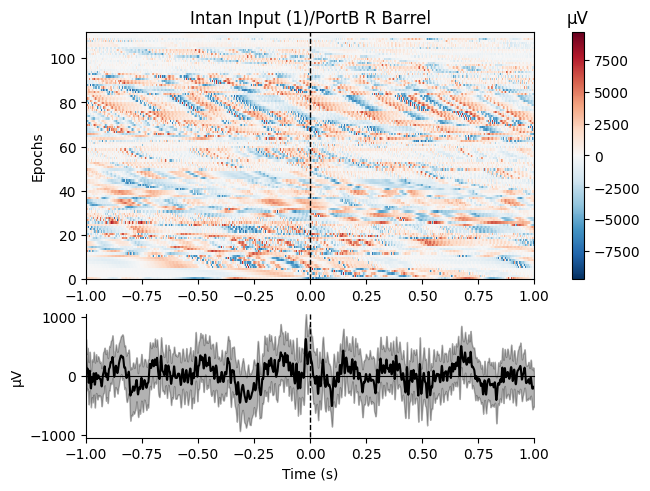

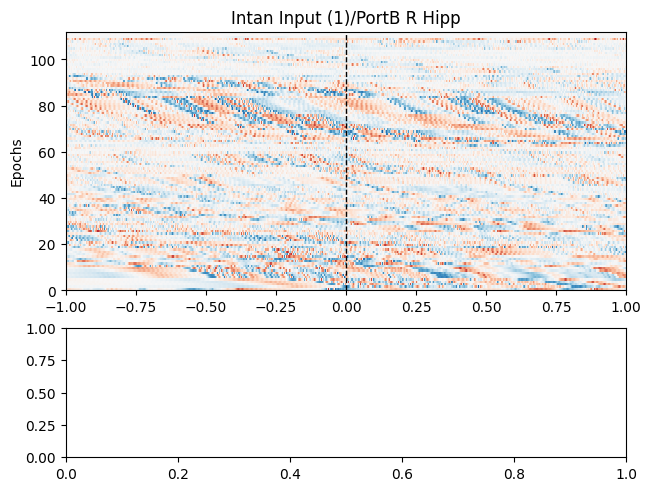

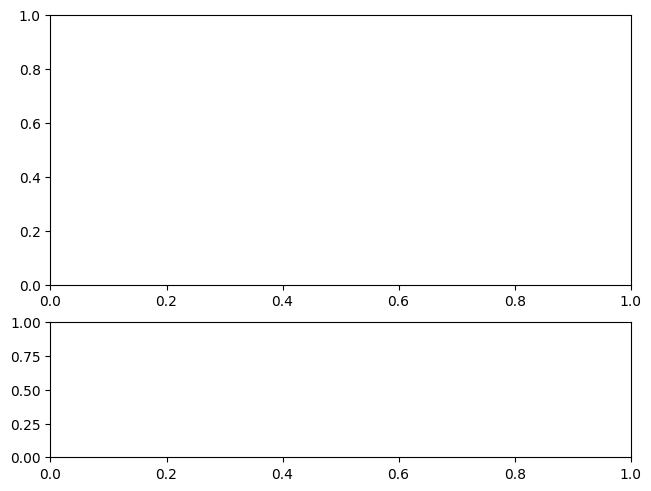

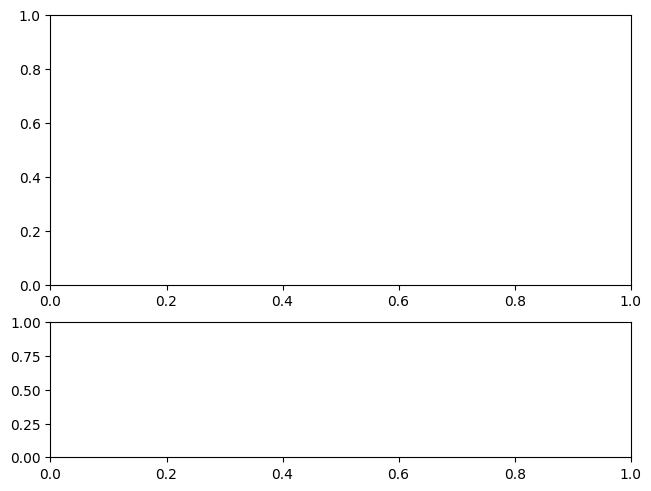

In [17]:
tfr_spike, tfr_baseline = analyze_peri_spike_tfr(mne_obj, tmin=-1, tmax=1)